In [37]:
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [3]:
energy_data = pd.read_csv('energy_dataset.csv', error_bad_lines=False)
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [26]:
print("forecast solar day ahead: ", len(energy_data["forecast solar day ahead"].unique()))
print("generation fossil oil: ", len(energy_data["generation fossil oil"].unique()))
print("generation other renewable: ", len(energy_data["generation other renewable"].unique()))

forecast solar day ahead:  5356
generation fossil oil:  322
generation other renewable:  79


In [27]:
def f_kde(data_name):
    
    column = data_name

    # fit density
    model = KernelDensity(bandwidth=2, kernel='gaussian')
    column = column.values.reshape((len(column), 1))
    model.fit(column)

    # sample probabilities for a range of outcomes
    min_amount, max_amount = data_name.min(), data_name.max()
    values = asarray([value for value in range(int(min_amount), int(max_amount))])
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = exp(probabilities)

    # plot the histogram and pdf
    
    sns.histplot(data_name, kde=False, bins=int(5 * math.log10(len(air_data.index))), stat='density')
    plt.plot(values[:], probabilities, color='r')


In [28]:
sns.set_theme(style="whitegrid")

In [31]:
n = len(energy_data.index)

In [19]:
print("weather size: ", len(weather_data.index))
print("pressure: ", len(weather_data.pressure.unique()))
print("humidity: ", len(weather_data.humidity.unique()))
print("temp: ", len(weather_data.temp.unique()))
print("weather_main: ", len(weather_data.weather_main.unique()))
print("wind_deg: ", len(weather_data.wind_deg.unique()))

weather size:  178396
pressure:  190
humidity:  100
temp:  20743
weather_main:  12
wind_deg:  361


In [39]:
#generation hydro water reservoir
ghwr_data = energy_data["generation hydro water reservoir"]



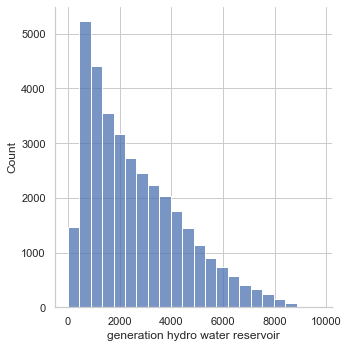

In [35]:
ghwr_hist = sns.displot(ghwr_data, bins = int(5 * math.log10(n)), kde = False)

In [38]:
f_kde(ghwr_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# generate a sample
column = air_dataset['temp']
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
column = column.values.reshape((len(column), 1))
model.fit(column)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(-20, 50)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
plt.figure(figsize = (12, 10))
pyplot.hist(column, bins=80, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()